# 2020-06-15: Analyzing Augusto's MS2 data

I ended up going off the rails last notebook and doing a bunch of work on analyzing confocal MS2 data, which has some interesting differences from lattice data, particularly the fact that nuclei are arranged in a monolayer which makes them much easier to segment. 


In [1]:
# Import public packages.
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi 
from importlib import reload
import pickle
import czifile
%matplotlib inline

# Import my packages.
import sys
sys.path.append('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin')
import imagep as imp
reload(imp)
from imagep import viewer, save_pickle, load_pickle, box_spots

In [2]:
stack = czifile.imread('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/EVE_D11-14.czi')
stack = np.squeeze(stack)
stack = np.swapaxes(stack,0,1)
stack = stack[:,0:20]

### Note:
Changed __segment_nuclei3D_monolayer__ to make a 3D mask out of the 2D mask. Just repeats the 2D mask enough times to fill the first dimension of the input stack.

In [30]:
mask4d = imp.segment_nuclei4D(stack[1], imp.segment_nuclei3D_monolayer, imp.update_labels_withmemory, 5, sigma1=4, min_seed_dist=13, size_max=5000)


In [4]:
viewer(mask4d, 'tzxy')

interactive(children=(Dropdown(description='Color', options=('viridis', 'magma', 'inferno', 'plasma', 'Greens'…

In [3]:
#nucmask_file = '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/EVE_D11-14_nucmask.pkl'
#save_pickle(mask4d, nucmask_file)
mask4d = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/EVE_D11-14_nucmask.pkl')

In [12]:
spot_data = imp.ms2_segment_stack(stack, mask4d, peak_window_size=(20,15,15), h_stringency=0, xy_max_width=10)



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [13]:
save_pickle(spot_data,'/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/EVE_D11-14_spot_data.pkl')

In [8]:
def quickview_ms2(stack, spot_data, channel=0):
    """View image stack with boxes drawn around detected spots
    
    Args:
        stack: ndarray
            5d image stack [c,t,z,x,y]
        spot_data: dict of ndarrays
            Data containing tracking of spots detected. Dict entries are unique 
            spot IDs (numeric 1...), rows of ndarray are detections of the spot 
            in a single frame. Time must be column 0, [z,x,y] in columns 2:4.
        channel: int
            Channel (dimension 0) to be viewed
    """
    substack = stack[channel]
    boxes = box_spots(substack, spot_data, halfwidth_xy=6, linewidth=2)
    viewer(boxes.max(axis=1), 'txy', 15)

In [11]:
quickview_ms2(stack, spot_data)

interactive(children=(Dropdown(description='Color', options=('viridis', 'magma', 'inferno', 'plasma', 'Greens'…

## Reworking MS2 segmentation
OK, I realize there's a problem. The problem is that the MS2 spot detection takes forever, and the time is spent on the fitting. It's not that it takes so long to run, it's that if you need to re-run it just to use different filters on the fits, it is ridiculous to re-do the fits. It seems obvious that a better way to structure this is to do the fitting on every frame, store that, and then do the filtering and connecting on that object separately. It doesn't change anything algorithmically (all the underlying processes are the same), but it's a much smarter way to organize it.

Going to write three functions:

1. Fit a 4D stack
2. Filter fit data from 4D stack, put it into dictionary format.
3. Connect fit data (this may not need to be updated at all--it shouldn't).

In [16]:
def fit_ms2(stack, peak_window_size=(70,50,50), sigma_small=0.5, 
                   sigma_big=4, bg_radius=4, fitwindow_rad_xy=5, 
                   fitwindow_rad_z=9):  
    """Perform 3D gaussian fitting on local maxima in a 4D image stack
    
    Alrigthm: bandbass filter -> background subtraction -> find local maxima
    -> fit gaussian to windows around maxima
    
    Args:
        stack: ndarray
            4D image stack [t,z,x,y] containing MS2 spots
        peak_window_size: tuple of three ints
            Size in [z,x,y] of window used to find local maxima. Typically
            set to the approximage dimensions of nuclei.
        sigma_small: numeric
            Lower sigma for difference-of-gaussians bandpass filter
        sigma_small: numeric
            Upper sigma for difference-of-gaussians bandpass filter
        bg_radius: int
            Radius for minimum filter used for background subtraction
        fitwindow_rad_xy: int
            Radius in pixels in the xy-dimension of the window around local
            maxima peaks within which to do gaussian fitting.
        fitwindow_rad_z: int
            Radius in pixels in the z-dimension of the window around local
            maxima peaks within which to do gaussian fitting.
    
    Returns:
        fit_data: list of ndarrays
            Each entry in the list is a time point (frame). Each row in
            array is a fit (a single local maxima), columns are: 0: center 
            z-coordinate, 1: center x-coordinate, 2: center y-coordinate, 
            3: width_z, 4: fit_height, 5: width_x, 6: width_y). Coordinates 
            are adjusted so that if fit center lies outside the image, 
            center is moved to the edge.
    """
    def get_fitwindow(data, peak, xy_rad=5, z_rad=9):
        """Retrieve section of image stack corresponding to given
        window around a point"""
        zmin = max(0,peak[0] - z_rad)
        zmax = min(data.shape[0] - 1, peak[0] + z_rad)
        xmin = max(0,peak[1] - xy_rad)
        xmax = min(data.shape[1] - 1, peak[1] + xy_rad)
        ymin = max(0,peak[2] - xy_rad)
        ymax = min(data.shape[2] - 1, peak[2] + xy_rad)
        # Get adjustments in each direction — value to subtract from relative
        # coordinates to center them at 0,0,0 in the window center.
        z_adj, x_adj, y_adj = int((zmax-zmin)/2), int((xmax-xmin)/2), int((ymax-ymin)/2)
        return data[zmin:(zmax+1), xmin:(xmax+1), ymin:(ymax+1)], z_adj, x_adj, y_adj
    
    def relabel(peak_ids, oldparams, mask):
        """Renumber labelmask and corresponding fit parameters
        Set background as 0, objects in order 1...end.
        """
        spot_data = {}
        peak_num = 1
        for peak in peak_ids:
            #coords = np.where(mask == peak)
            paramsnew = oldparams[peak-1,:] # object 1 will be fitparams row 0
            # Rearrange params from fit function so coordinates lead.
            spot_data[peak_num] = paramsnew[[1,2,3,0,4,5,6]]
            peak_num = peak_num + 1
        return spot_data

    def clamp(n, minn, maxn):
        """Bound a number between two constants"""
        return max(min(maxn, n), minn)
    
    def fit_frame(substack, peak_window_size, sigma_small, 
                   sigma_big, bg_radius, fitwindow_rad_xy, 
                   fitwindow_rad_z):
        """Perform 3D gaussian fitting on a 3D image stack."""
        
        # Filter and background subtract image.
        dog = dog_filter(substack, sigma_small, sigma_big)
        bg = ndi.filters.minimum_filter(dog, bg_radius)
        dog_bs = dog - bg

        # Make a labelmask corresponding to local maxima peaks.
        mask, peaks = peak_local_max_nD(dog_bs, peak_window_size)

        # Fit 3D gaussian in window surrounding each local maximum.
        fitparams = np.ndarray((0,7))
        for peak in peaks:
            fitwindow, z_adj, x_adj, y_adj = get_fitwindow(substack, peak, fitwindow_rad_xy, 
                fitwindow_rad_z)
            opt = fitgaussian3d(fitwindow)
            if opt.success:
                peak_fitparams = opt.x
                # Move center coordinates to match center of gaussian fit, ensure they're within image. 
                # If they're outside the image, coordinate is assigned as the edge of the image.
                peak_fitparams[0] = clamp(int(peak[0] + peak_fitparams[0] - z_adj), 0, substack.shape[-3]-1)
                peak_fitparams[1] = clamp(int(peak[1] + peak_fitparams[1] - x_adj), 0, substack.shape[-2]-1)
                peak_fitparams[2] = clamp(int(peak[2] + peak_fitparams[2] - y_adj), 0, substack.shape[-1]-1)
                fitparams = np.vstack((fitparams, peak_fitparams))
            # If fit fails, add dummy entry for spot.
            else:
                fitparams = np.vstack((fitparams, np.array([0,0,0,0,np.inf,np.inf,np.inf])))
        return fitparams
    
    #### Main ####
    # Do fitting on first frame.
    fit_data_frame0 = fit_frame(stack[0], peak_window_size, sigma_small, 
                   sigma_big, bg_radius, fitwindow_rad_xy, 
                   fitwindow_rad_z)
    # Make fit_data a list of ndarrays.
    fit_data = [fit_data_frame0]
    
    # Fit the rest of the frames, add their data to fit_data.
    for i in range(1, stack.shape[0]):
        print(i)
        fit_data_thisframe = fit_frame(stack[i], peak_window_size, sigma_small, 
                   sigma_big, bg_radius, fitwindow_rad_xy, 
                   fitwindow_rad_z)
        fit_data.append(fit_data_thisframe)
        
    return fit_data

In [154]:
def filter_ms2fits(stack, fit_data, h_stringency=1, xy_max_width=15):
    """Filter MS2 spot fit data based on fit parameters
    
    Select spots that have a minimum fit height (intensity) and a maximum 
    lateral (xy) width.
    
    Args:
        stack: ndarray
            4D imaging stack [t,z,x,y] that the fitting was performed on
        fit_data: list of ndarrays
            Each entry in list is a distinct frame (in time), rows in array
            are individual spot fits and columns are 0: center 
            z-coordinate, 1: center x-coordinate, 2: center y-coordinate, 
            3: width_z, 4: fit_height, 5: width_x, 6: width_y.
        h_stringency: numeric
            Determines minimum fit height cutoff, expressed as the number
            of standard deviations above the mean for the entire stack.
        xy_max_width: numeric
            Maximum width (in pixels) of the mean of the x and y widths of
            the fit
    
    Returns:
        fit_data: list of ndarrays
            Input data, retaining only rows that pass filter.  
    """
    
    fit_data = fit_data.copy()
    for t in range(0, len(fit_data)):
        frame_data = fit_data[t]
        # Define threshold for height.
        mean_ = np.mean(stack[t])
        std = np.std(stack[t])
        h_thresh = mean_ + (std * h_stringency)
        # Filter array based on min height and max width.
        frame_data_filtered = frame_data[(frame_data[:,3] >= h_thresh) &
                    (np.mean(frame_data[:,5:7], axis=1) < xy_max_width),:]
        fit_data[t] = frame_data_filtered
    return fit_data

In [109]:
reload(imp)
from imagep import dog_filter, peak_local_max_nD
from fitting import fitgaussian3d
test = stack[0,0:3,:,200:300,0:1000]
fit_data2=fit_ms2(test)

1
2


In [110]:
fit_data2[0]

array([[0.00000000e+00, 9.00000000e+00, 6.19000000e+02, 1.79520154e+03,
        2.02821085e+01, 3.26250454e+01, 2.14983298e+01],
       [0.00000000e+00, 9.00000000e+00, 8.47000000e+02, 1.75054490e+03,
        1.69843966e+01, 5.07017530e+01, 1.94191970e+01],
       [0.00000000e+00, 1.20000000e+01, 1.02000000e+02, 1.85538706e+03,
        1.90434725e+01, 5.17509803e+01, 1.95830899e+01],
       [0.00000000e+00, 1.90000000e+01, 6.00000000e+00, 1.87945136e+03,
        1.30424712e+01, 3.08964944e+01, 3.29274870e+01],
       [0.00000000e+00, 4.70000000e+01, 1.23000000e+02, 2.04254391e+03,
        9.25347309e+00, 2.64775990e+01, 1.68342298e+01],
       [0.00000000e+00, 4.80000000e+01, 3.84000000e+02, 1.92085120e+03,
        1.37101614e+01, 1.10059291e+01, 9.40490456e+01],
       [0.00000000e+00, 5.30000000e+01, 6.31000000e+02, 1.77512410e+03,
        2.13928180e+01, 1.36287849e+01, 1.18004089e+01],
       [0.00000000e+00, 4.80000000e+01, 9.40000000e+01, 1.89588895e+03,
        1.68801699e+01, 1

In [58]:
filtered_fits=filter_ms2fits(stack[0],fit_data, )

In [126]:
def connect_ms2_frames(spot_data, nucmask, max_frame_gap=1, max_jump=10, 
    scale_xy=1, scale_z=1):
    """Connect detected MS2 spots through multiple time frames.
    
    Spots detected in new frame are connected to spots in previous frames
    if they are within specified distance (max_jump). Spots can "disappear" 
    for a number of frames defined by max_frame_gap. Spots that cannot be 
    connected to spots from prior frames are initialized as new spots.
    
    Args:
        spot_data: list of ndarrays
            Each entry in list is a distinct frame (in time), rows in array
            are individual detected spots and columns are 0: center 
            z-coordinate, 1: center x-coordinate, 2: center y-coordinate, 
            3: width_z, 4: fit_height, 5: width_x, 6: width_y.
        nucmask: ndarray
            4D labelmask of dimensions [t,z,x,y] of segmented nuclei. 0 is 
            background (not a nucleus) and nuclei have integer labels.
        max_frame_gap: int
            Maximum number of frames from which spot can be absent and still
            connected across the gap. Example: for a value of 1, a spot
            detected in frame 6 and absent from frame 7 can be connected to
            a spot in frame 8, but a spot in frame 5 cannot be connected to
            frame 8 if it is absent in frames 6 and 7.
        max_jump: numeric
            Maximum 3D displacement between frames for two spots to be connected
        scale_xy: numeric
            Distance scale for xy direction (typically: nm per pixel)
        scale_z: numeric
            Distance scale for z direction (typically: nm per pixel)
        
    Returns:
        connected_data: dict of ndarrays
            Each key is a unique spot tracked across 1 or more frames. Each row
            of array is the spot's data for a single frame, with columns 0: frame
            number (t), 1: nucleus ID, 2: center Z-coordinate, 3: center X-coord-
            inate, 4: center Y-coordinate, 5: fit height, 6: fit z_width, 7: fit
            x_width, 8: fit y_width
    """
    def initialize_new_spot(new_spot_data, connected_data):
        """Initialize new spot with next numeric ID and entry in connected_data."""
        if (connected_data.keys()):
            new_id = max(connected_data.keys()) + 1
        else:
            new_id = 1
        connected_data[new_id] = np.expand_dims(new_spot_data, 0)

    def sq_euc_distance(coords1, coords2, scale_z=1, scale_xy=1):
        """Find the squared euclidean distance between two points."""
        z2 = ((coords2[0] - coords1[0]) * scale_z) ** 2
        x2 = ((coords2[1] - coords1[1]) * scale_xy) ** 2
        y2 = ((coords2[2] - coords1[2]) * scale_xy) ** 2
        sed = z2 + x2 + y2
        return sed
    
    def coord_list_t(connected_data, t):
        """Make a list of [z,x,y] coordinate tuples for all spots in a given
        frame"""
        coord_list = []
        for spot_id in connected_data:
            this_spot_data = connected_data[spot_id]
            row = this_spot_data[this_spot_data[:,0] == t]
            if (len(row) > 0):
                row = list(row[0])
                spot_coords = [spot_id] + row[2:5]
                coord_list.append(spot_coords)
        return coord_list
            
    
    def find_nearest_spot(this_coord, coord_list, scale_z, scale_xy):
        """For a given point, find the closest spot in a coordinate list
        and the distance between the points."""
        closest_sed = np.inf
        closest_spot = 0
        for test_data in coord_list:
            test_spot_id = test_data[0]
            test_coords = (test_data[1:4])
            sed = sq_euc_distance(test_coords, this_coord, scale_z, scale_xy)
            if (sed < closest_sed):
                closest_sed = sed
                closest_spot = test_spot_id
                closest_spot_coords = test_coords
        return closest_spot, np.sqrt(closest_sed), closest_spot_coords

    def update_spot(this_spot_data, connected_data, scale_z, scale_xy, max_frame_gap, 
                    t):
        """Walk back one frame at a time within limit set by maximum gap, search 
        for a nearest spot that is within the maximum allowable jump, handle 
        duplicates, add connected points to connected_data."""
        this_spot_coords = (this_spot_data[2:5])
        # Walk back one frame at a time.
        for t_lag in range(1, max_frame_gap + 2):
            if ((t - t_lag) >= 0):
                # Get nearest spot in the current frame.
                spot_coords_tlag = coord_list_t(connected_data, t - t_lag)
                # If there are no previously detected spots, break from for loop and initialize new spot entry.
                if (len(spot_coords_tlag) == 0):
                    break
                nearest_spot_id, dist, nearest_spot_coords = find_nearest_spot(this_spot_coords, spot_coords_tlag, scale_z, scale_xy)
                # Check is spot is within max distance.
                if (dist <= max_jump):
                    this_spot_nucID = this_spot_data[1]
                    nearest_spot_nucID = connected_data[nearest_spot_id][-1,1]
                    # Check if there's already a spot added for this time.
                    existing = connected_data[nearest_spot_id][connected_data[nearest_spot_id][:,0] == t]
                    # If there's no existing spot, add this spot to the end of the data for connected spot.
                    if (len(existing) == 0):
                        connected_data[nearest_spot_id] = np.append(connected_data[nearest_spot_id], [this_spot_data], axis=0)
                        return
                    # If there is an existing spot, if the current spot is closer to the previous-frame spot
                    # than the existing entry, replace it. Otherwise, continue looking in previous frames (if
                    # applicable) and eventually create new spot after for loop. I'm not sure this is the best
                    # behavior--may consider dumping out of for loop and creating new spot rather than looking
                    # to previous frames in this situation.
                    else:
                        existing_dist = np.sqrt(sq_euc_distance(nearest_spot_coords, existing[0,2:5], scale_z, scale_xy))
                        # If the the current spot is closer than the existing spot, replace 
                        # existing and initialize it as a new spot.
                        if (dist < existing_dist):
                            row_index = np.where(connected_data[nearest_spot_id][:,0] == t)[0][0]
                            superseded_spot_data = connected_data[nearest_spot_id][row_index]
                            # Superseded spot from this frame gets bumped to be a new spot.
                            initialize_new_spot(superseded_spot_data, connected_data)
                            # Replace data for superseded spot with this spot's data.
                            connected_data[nearest_spot_id][row_index] = this_spot_data
                            return

        # If no suitable spot was found in previous frames, make a new spot.
        initialize_new_spot(this_spot_data, connected_data)
    
    def add_time_nuc(this_spot_data, t, nucmask):
        """ Append the frame number (t) and nucleus ID to front of spot_data"""
        spot_coords = tuple(np.append([t], this_spot_data[0:3]).astype(int))
        nuc_id = nucmask[spot_coords]
        # Add time and nuclear ID columns to spot data and call update to search 
        # for connected spots in previous frames.
        this_spot_data = np.append([t, nuc_id], this_spot_data)
        return this_spot_data
    
    def initialize_connected_data(frame_data):
        """Initialize connected_data structure as a dict where each entry
        is a unique spot and the array rows are data for single frames"""
        connected_data = {}
        for i in range(0, len(frame_data)):
            this_spot_data = add_time_nuc(frame_data[i], 0, nucmask)
            connected_data[i+1] = np.array([this_spot_data])
        return connected_data
        
    # Main
    input_data = spot_data.copy()
    connected_data = initialize_connected_data(input_data[0])

    # Go through each frame, attempt to connect each detected spot to previous spots.
    for t in range(1, len(input_data)):
        frame_data = input_data[t]
        for this_spot_data in frame_data:
            this_spot_data = add_time_nuc(this_spot_data, t, nucmask)
            update_spot(this_spot_data, connected_data, scale_z, scale_xy, max_frame_gap, t)
    
    return connected_data  

In [186]:
def filter_spot_duration(connected_data, min_len):
    """"""
    filtered_data = {}
    for spot in connected_data:
        if (connected_data[spot].shape[0] >= min_len):
            filtered_data[spot] = connected_data[spot]
    return filtered_data

In [217]:
save_pickle(fit_data4, '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/EVE_D11-14_fit_data.pkl')

In [191]:
filtered_fits=filter_ms2fits(test,fit_data4, h_stringency=0.2, xy_max_width=15)

In [192]:
connected_data = connect_ms2_frames(filtered_fits, np.ones_like(test))

In [197]:
connected_data_f = filter_spot_duration(connected_data,3)

In [211]:
%matplotlib inline
quickview_ms2(stack, connected_data_f)

interactive(children=(Dropdown(description='Color', index=4, options=('inferno', 'gray_r', 'magma', 'Greens', …

OK, that's done. Took all day, but now I can play with fitting parameters for free. Definitely a better way to go. 

## Analyzing some data

Onward and upward. First, I want to redo that with a proper nuclear mask.

In [214]:
reload(imp)
nucmask = imp.segment_nuclei4D(stack[1], imp.segment_nuclei3D_monolayer, imp.update_labels_withmemory, 5, sigma1=4, min_seed_dist=13, size_max=5000)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [215]:
connected_data = connect_ms2_frames(filtered_fits, nucmask)

In [216]:
save_pickle(nucmask, '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/EVE_D11-14_nucmask.pkl')
save_pickle(connected_data, '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/EVE_D11-14_spot_data.pkl')

In [238]:
connected_data_f = filter_spot_duration(connected_data,3)

In [237]:
connected_data_f.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185])

In [235]:
connected_data_f[21]

array([[0.00000000e+00, 1.64000000e+02, 0.00000000e+00, 1.20000000e+02,
        6.90000000e+02, 3.74369219e+04, 1.14096449e+00, 1.15324810e+00,
        1.26676558e+00],
       [1.00000000e+00, 1.64000000e+02, 0.00000000e+00, 1.20000000e+02,
        6.93000000e+02, 3.90304223e+04, 1.09025262e+00, 1.10812968e+00,
        1.15020604e+00],
       [2.00000000e+00, 1.64000000e+02, 0.00000000e+00, 1.20000000e+02,
        6.93000000e+02, 4.07994251e+04, 1.25105487e+00, 1.07249263e+00,
        1.06507875e+00],
       [3.00000000e+00, 1.64000000e+02, 0.00000000e+00, 1.23000000e+02,
        6.93000000e+02, 9.55241374e+03, 4.73966800e+00, 2.48233281e+00,
        2.57415171e+00],
       [4.00000000e+00, 1.64000000e+02, 0.00000000e+00, 1.23000000e+02,
        6.93000000e+02, 5.35754295e+03, 6.34697265e+00, 3.58465773e+00,
        3.85402043e+00],
       [5.00000000e+00, 1.64000000e+02, 0.00000000e+00, 1.23000000e+02,
        6.93000000e+02, 3.91258064e+03, 7.54893511e+00, 4.55230901e+00,
        4.8

In [228]:
viewer(nucmask, 'tzxy')

interactive(children=(Dropdown(description='Color', index=4, options=('inferno', 'gray_r', 'magma', 'Greens', …

In [229]:
ids, counts = np.unique(nucmask, return_counts=True)

In [232]:
counts / 20

array([2.33597385e+06, 8.52705000e+03, 4.48140000e+03, 3.45450000e+03,
       6.13305000e+03, 2.43495000e+03, 2.36565000e+03, 7.42140000e+03,
       4.29765000e+03, 5.17440000e+03, 3.01770000e+03, 8.61105000e+03,
       6.83760000e+03, 5.87685000e+03, 8.90400000e+03, 6.76515000e+03,
       3.62250000e+03, 1.03950000e+02, 1.76925000e+03, 4.01835000e+03,
       6.23490000e+03, 5.77605000e+03, 3.78735000e+03, 9.24525000e+03,
       9.88155000e+03, 8.62470000e+03, 1.01902500e+04, 9.62430000e+03,
       8.54490000e+03, 1.03362000e+04, 9.14655000e+03, 8.80425000e+03,
       7.73745000e+03, 9.39330000e+03, 2.69430000e+03, 9.25365000e+03,
       8.63835000e+03, 8.39055000e+03, 9.72090000e+03, 9.49935000e+03,
       9.18750000e+03, 9.70305000e+03, 8.84205000e+03, 9.55815000e+03,
       9.94455000e+03, 8.15745000e+03, 1.05199500e+04, 8.68980000e+03,
       9.00585000e+03, 9.67890000e+03, 9.28725000e+03, 1.58655000e+03,
       8.91030000e+03, 9.25365000e+03, 9.57495000e+03, 1.02186000e+04,
      

## Revising nuclear segmentation

One of the challenges of working with confocal data is the refocusing breaks. Connecting spots and nuclei across these breaks will take some work. For nuclei, I want to re-work my routine slightly to make it into four functions:

1. Segment 3D stacks (already written)
2. Take a 3D segmenetation function and build an unconnected 4D labelmask.
2. update_labels to connect labels two 3D stacks (update_labels — already exists)
3. A function to connect labels in an unconnected 4D stack (based on update_labels_withmemory).

Should be a straightforward reworking, requiring only two new functions and only minor reworking of those. User would only have to call two functions (or one wrapper).

In [241]:
test = stack[1,0:2,:,0:200,0:200]

In [399]:
############################################################################

def segment_nuclei_4dstack(stack, seg_func, **kwargs):
    """Perform segmentation on a time-series of 3D stacks
    
    Accepts a function that performs nuclear segmentation on a 3D image stack, 
    calls this function on each frame of a 4D image stack, and returns a 4D 
    nuclear mask. Individual time frames are independently segmented and
    labels are not connected between them.
    
    Args:
        stack: ndarray
            4D image stack [t,z,x,y]
        seg_func: function
            A function that performs segmentation on a 3D image stack
        **kwargs: key-word arguments
            Arguments to supply to segmentation function
    
    Returns:
        labelmask: ndarray
            Mask in the shape of input stack with nuclei independently
            segmented at each time point.
    """
    # Segment first frame, initialize 4D labelmask.
    frame0 = seg_func(stack[0], **kwargs)
    labelmask = np.array([frame0])
    # Segment subsequent frames, stack results together.
    for n in range(1, stack.shape[0]):
        print(n)
        frame = seg_func(stack[n], **kwargs)
        labelmask = np.vstack((labelmask, [frame]))
    
    return labelmask
        
        
a=stack_segment_nuclei_stack(test, imp.segment_nuclei3D_monolayer, sigma1=4, min_seed_dist=13, size_max=5000)

KeyboardInterrupt: 

In [254]:
viewer(a,'tzxy')

interactive(children=(Dropdown(description='Color', index=4, options=('inferno', 'gray_r', 'magma', 'Greens', …

In [396]:
reload(imp)
from imagep import update_labels
def connect_nuclei(maskstack, max_frames_skipped=2, 
                             update_func=update_labels):
    """Match labels in a labelmask to masks from previous frames
    
    Takes a stack of nuclear masks, for each frame, walk backward in time 
    looking for segmented nuclei in previous frames that correspond to 
    nuclei in the new frame. Default is to use update_labels function to 
    do comparison of two masks, but this can be changed. Nuclei in a frame
    that cannot be matched to previous nucleus are kept and initialized 
    with new labels (change from previous behavior).
    
    Note: Written with adding 3d masks to 4d stacks, but works for 3d-
    2d.
    
    Args:
        maskstack:
            4D labelmask [t,z,x,y] of segmented nuclei, labels not connected
            between time frames (mask at each time generated independently).
        max_frames_skipped: int
            Maximum number of frames that can be "skipped" to find a nucleus
            to connect to. Compensates for errors in segmentation that cause
            nuclei to sometimes drop from frames. e.g., for a value of 1, 
            function will search for a connected nucleus in the last frame 
            and, if unsuccessful, in the second-to-last frame.
        update_func: function
            Function that takes two label masks, updates labels in the second
            based on matches in the first. Default is to use update_labels.
    
    Returns:
        connected_mask: ndarray
            4D labelmask of same shape as maskstack with object labels connected
            between frames. 
    """
    # Initialize blank mask.
    connected_mask = np.zeros_like(maskstack)
    # Add first frame.
    connected_mask[0] = maskstack[0]
    # Walk through subsequent frames, connecting them to previous frames.
    for n in range(1, maskstack.shape[0]):
        print('frame ' + str(n))
        newmask = maskstack[n]
        # Step sequentially backwards through frames, bound by max skip.
        for i in range(n-1, n-2-max_frames_skipped, -1):
            # Make sure the frame exists.
            if (i >= 0):
                print(i)
                # Make updated mask with connections to earlier frame.
                mask_updated_thisframe = update_func(connected_mask[i], newmask)
                # Only update objects that are connected in this frame but were NOT
                # connected to a more recent frame. Do this by restricting updates
                # to positions in connected_mask that are currently 0. Positions that
                # are either non-zero in the current connected_mask or 0 in both are
                # kept the same. Only pixels that are non-zero in new update and 0
                # in current mask are changed (to the labels from the current frame).
                connected_mask[n] = np.where((connected_mask[n] == 0) & (mask_updated_thisframe != 0),
                    mask_updated_thisframe, connected_mask[n])
                #connected_mask[n] = mask_updated_thisframe
        # Initialize un-matched nuclei with new labels.
        unmatched = newmask[(newmask != 0) & (connected_mask[n] == 0)]
        unmatched_labels = np.unique(unmatched)
        for orphan in unmatched_labels:
            new_label = connected_mask.max() + 1
            connected_mask[n][newmask == orphan] = new_label
            
    return connected_mask

In [392]:
a1 = test[0]
a2 = test[1]
unmatched = a2[(a2 != 0) & (a1 == 0)]

In [395]:
np.unique(unmatched)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 18

In [394]:
viewer([a1,a2],'zxy')

interactive(children=(Dropdown(description='Color', index=4, options=('inferno', 'gray_r', 'magma', 'Greens', …

In [269]:
viewer(b,'tzxy')

interactive(children=(Dropdown(description='Color', index=4, options=('inferno', 'gray_r', 'magma', 'Greens', …

In [270]:
nmask = stack_segment_nuclei_4dstack(stack[1], imp.segment_nuclei3D_monolayer, sigma1=4, min_seed_dist=13, size_max=5000)

In [284]:
nmask_c = connect_nuclei(nmask, 2)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [286]:
viewer(nmask_c,'tzxy',12)

interactive(children=(Dropdown(description='Color', index=4, options=('inferno', 'gray_r', 'magma', 'Greens', …

In [288]:
############################################################################
def read_czi(filename, trim=False, swapaxes=True):
    """Read a czi file into an ndarray
    
    Args:
        filename: string
            Path to czi file
        trim: bool
            If true, remove last frame
        swapaxes: bool
            If true, switches first two axes to produce a stack order ctzxy
            
    Returns:
        stack: ndarray
            Image stack in dimensions [t,c,z,x,y] (no swap) or 
            [c,t,z,x,y] (swapped)
    """
    stack = czifile.imread(filename)
    stack = np.squeeze(stack)
    # Trim off last frame 
    if trim:
        stack = stack[0:stack.shape[0]-1]
    if (swapaxes):
        stack = np.swapaxes(stack,0,1)
    return stack

In [292]:
stack2 = read_czi('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/EVE_D11-13.czi', True)

In [295]:
nmask2 = segment_nuclei_4dstack(stack2[1], imp.segment_nuclei3D_monolayer, sigma1=4, min_seed_dist=13, size_max=5000)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


In [296]:
maskstack = np.vstack((nmask2, nmask))

In [340]:
# Randomize labels in each frame to test connecting functions.
test = np.zeros_like(maskstack)
for n in range(0,test.shape[0]):
    labels = np.unique(maskstack[n])[1:]
    labels_shuffle = np.copy(labels)
    random.shuffle(labels_shuffle)
    for i in range(0, len(labels)):
        old_label = labels[i]
        new_label = labels_shuffle[i]
        test[n][maskstack[n] == old_label] = new_label

In [310]:
viewer(test,'tzxy')

interactive(children=(Dropdown(description='Color', index=4, options=('inferno', 'gray_r', 'magma', 'Greens', …

In [397]:
# Fired at 11:05
reload(imp)
test_c6 = connect_nuclei(test[24:30], 2, imp.update_labels)

frame 1
0
frame 2
1
0
frame 3
2
1
0
frame 4
3
2
1
frame 5
4
3
2


In [561]:
viewer(test_c6, 'tzxy',13)

interactive(children=(Dropdown(description='Color', index=4, options=('inferno', 'gray_r', 'magma', 'Greens', …

In [343]:
update = imp.update_labels(test[0],test[1])

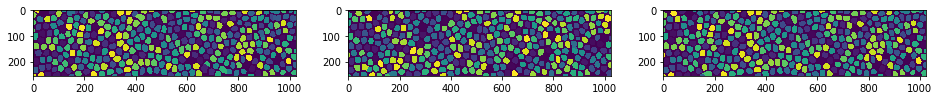

In [344]:
ax=imp.qax(3)
ax[0].imshow(test[0,0])
ax[1].imshow(test[1,0])
ax[2].imshow(update[0])

In [3]:
mask = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/EVE_D11-14_nucmask.pkl')

In [4]:
viewer(mask, 'tzxy')

interactive(children=(Dropdown(description='Color', index=3, options=('cividis', 'plasma', 'Greens', 'viridis'…

In [6]:
test = np.zeros_like(mask)
test=test[0:8]
test[0:3,:,100:200,100:200] = 1
test[4:,:,150:250,150:250] = 1
viewer(test,'tzxy')

interactive(children=(Dropdown(description='Color', index=3, options=('cividis', 'plasma', 'Greens', 'viridis'…

In [9]:
test2 = mask[6:11]
test2[2][test2[2] == 100] = 0
test2[2][test2[2] == 101] = 0
test2[2][test2[2] == 103] = 0
test2[2][test2[2] == 200] = 0
test2[2][test2[2] == 201] = 0
viewer(test2.astype('bool'), 'tzxy')

interactive(children=(Dropdown(description='Color', index=3, options=('cividis', 'plasma', 'Greens', 'viridis'…

In [10]:
from imagep import get_object_centroid
# Interpolate nuclei.
#mask=np.copy(test)
############################################################################
def interpolate_nuclear_mask(mask, max_missing_frames):
    """Fill-in frames of nuclear mask to compensate for dropout.
    
    So far all nuclear segmentation routines I've tried are susceptible to
    occasional dropout — cases where a nucleus is absent from one or more 
    frames. This function fills in those gaps. Interpolated nuclei have the 
    same shape as the nucleus in the preceding frame with the centroid of
    that shape lying at the mean position of the centroids of the nucleus
    in the preceding and succeeding frame. So if a nucleus is missing from 
    frame 4, the centroid of the nucleus is taken in frame 3 and 5 and the 
    mean of those is used as the centroid of the new nucleus. All the pixels
    belonging to the nucleus in frame 3 are then shifted to match this new
    centroid and this is the final interpolated nuclear object.
    
    Args:
        mask: ndarray
            4D labelmask of segmented nuclei
        max_missing_frames: int
            Maximum allowable number of consecutive frames missing a nucleus for
            interpolation to be executed.
            
    Returns:
        newmask: ndarray
            Labelmask in the same shape as input with interpolated nuclei.
    
    """
    def find_surrounding_frames(frame, frames_with):
        """Find nearest frames containing nucleus before and after frame missing nucleus"""
        # If frame is missing from the beginning, return initial frame twice.
        if (frame < frames_with[0]):
            return frames_with[0], frames_with[0], frames_with[0] - frame
        # If frame is missing from the end, return last frame twice.
        elif (frame > frames_with[-1]):
            return frames_with[-1], frames_with[-1], frame - frames_with[-1]
        # If frame is missing in the middle, return surrounding frames.
        else:
            for i in range(1, len(frames_with)):
                frame_before = frames_with[i-1]
                frame_after = frames_with[i]
                if (frame > frame_before and frame < frame_after):
                    return frame_before, frame_after, frame_after - frame_before - 1

    def interpolate(mask, newmask, label, frame, frames_with, coords, frame_before, frame_after):
        """Use position of nucleus in preceding and succeeding frames to interpolate 
        nucleus in missing frame"""
        # Find centroid of nucleus in before and after frames, take the mean centroid for
        # the position of interpolated nucleus.
        centroid_before = get_object_centroid(mask[frame_before], label)
        centroid_after = get_object_centroid(mask[frame_after], label)
        mean_centroid = [sum(y) / len(y) for y in zip(*(centroid_before, centroid_after))]
        mean_centroid = [int(i) for i in mean_centroid]
        # Get difference of mean centroid and before centroid.
        centroid_diff = ([mean_centroid[0] - centroid_before[0]])
        for i in range(1,len(mean_centroid)):
            centroid_diff = centroid_diff + ([mean_centroid[i] - centroid_before[i]])
        # Make a boolean for all the coordinates in the before frame.
        obj_bool = coords[0] == frame_before
        # Assign the frame number to the first position for all interpolated coordinates.
        interp_coords = tuple([np.repeat(frame, np.count_nonzero(obj_bool))])
        # For remaining dimensions, use centroid difference to "move" pixels of nucleus
        # from before frame to the interpolated position.
        for i in range(0, len(centroid_diff)):
            interp_coords = interp_coords + tuple([coords[i+1][obj_bool] + centroid_diff[i]])
        # Update newmask in place.
        newmask[interp_coords] = label

    # Main.
    newmask = np.copy(mask)
    labels = np.unique(mask)[1:]
    t_frames = np.arange(0,mask.shape[0])
    for label in labels:
        # Find all point coordinates with the label.
        coords = np.where(np.isin(mask, label))
        # Find frames containing and lacking label.
        frames_with = np.unique(coords[0])
        frames_without = t_frames[~np.isin(t_frames, frames_with)]
        # Interpolate nucleus for each frame lacking it.
        for frame in frames_without:
            frame_before, frame_after, num_consecutive_skipped = find_surrounding_frames(frame, frames_with)
            if (num_consecutive_skipped <= max_missing_frames):
                interpolate(mask, newmask, label, frame, frames_with, coords, frame_before, frame_after)
    return newmask
    
a=interpolate_nuclear_mask(test, np.inf)       
viewer(a,'tzxy')    

interactive(children=(Dropdown(description='Color', index=3, options=('cividis', 'plasma', 'Greens', 'viridis'…

In [13]:
#b=interpolate_nuclear_mask(test2, np.inf)
c=interpolate_nuclear_mask(test2, 0)

In [14]:
viewer(c.astype('bool'),'tzxy',12)

interactive(children=(Dropdown(description='Color', index=3, options=('cividis', 'plasma', 'Greens', 'viridis'…

In [17]:
test2 = mask[6:11]
test2[2:4][test2[2:4] == 100] = 0
test2[2:4][test2[2:4] == 101] = 0
test2[2:4][test2[2:4] == 103] = 0
test2[2:4][test2[2:4] == 200] = 0
test2[2:4][test2[2:4] == 201] = 0
viewer(test2.astype('bool'),'tzxy',12)

interactive(children=(Dropdown(description='Color', index=3, options=('cividis', 'plasma', 'Greens', 'viridis'…

In [18]:
d=interpolate_nuclear_mask(test2, 1)
e=interpolate_nuclear_mask(test2, 2)

In [19]:
viewer(d.astype('bool'),'tzxy')

interactive(children=(Dropdown(description='Color', index=3, options=('cividis', 'plasma', 'Greens', 'viridis'…

In [20]:
viewer(e.astype('bool'),'tzxy')

interactive(children=(Dropdown(description='Color', index=3, options=('cividis', 'plasma', 'Greens', 'viridis'…

## Taking stock

OK, well I managed to re-write everything, again. I now have a pretty decent czi segmentation routine...maybe. I'll need to write this up for myself so I can keep track of what I'm doing, since it's gotten pretty complex. I think the next step is to do what I was hoping to do to start: Run the segmentation on one of Augusto's datasets and begin to figure out how to do analysis on the spots. An interesting approach would be to use the histone channel as a control for "surge"-type analysis. 

## Testing everything on Augusto's data

In [23]:
reload(imp)
from imagep import read_czi
stack = read_czi('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/EVE_D11-14.czi', True)

In [25]:
mask_init14 = imp.segment_nuclei_4dstack(stack[1], imp.segment_nuclei3D_monolayer, sigma1=4, min_seed_dist=13, size_max=5000)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


In [27]:
mask_init = np.vstack((mask_init12, mask_init13, mask_init14))

In [42]:
imp.viewer(mask_init)

interactive(children=(Dropdown(description='Color', index=2, options=('Greens', 'magma', 'viridis', 'plasma', …

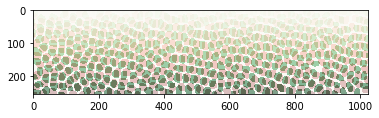

In [47]:
#ax=imp.qax(2)
plt.imshow(mask_init[38,0],cmap='Reds',alpha=0.5)
plt.imshow(mask_init[37,0],cmap='Greens',alpha=0.5)

In [40]:
reload(imp)
mask_conn = imp.connect_nuclei(mask_init)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


In [41]:
viewer(mask_conn,'tzxy')

interactive(children=(Dropdown(description='Color', index=2, options=('Greens', 'magma', 'viridis', 'plasma', …

In [14]:
reload(imp)
mask_interp = imp.interpolate_nuclear_mask(mask_conn)

In [15]:
viewer(mask_interp, 'tzxy')

interactive(children=(Dropdown(description='Color', index=2, options=('Greens', 'magma', 'viridis', 'plasma', …

In [17]:
b=np.vstack((mask_init,mask_init))

In [21]:
mask_init.shape

(15, 21, 256, 1024)

In [30]:
def get_default_order(n):
    
len(stack.shape)

5

In [34]:
'ctzxy'[5-2:]

'xy'

In [35]:
stack.ndim

5